<a href="https://colab.research.google.com/github/bmwenyemali/smartcoinsDataAnalysis/blob/main/smartcoins_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SmartCoins Data Analysis Portfolio

**Author:** Bienvenu M Mwenyemali  
**Data Source:** [SmartCoins App API](https://smartcoinsapp.com/api/coins)  
**Skills Demonstrated:** Python, Pandas, API Integration, Data Analysis, Visualization

---

## Project Overview
This notebook demonstrates comprehensive data analytics skills using cryptocurrency data from SmartCoins App. We will:
1. Extract data from API
2. Clean and transform data
3. Perform statistical analysis
4. Create custom scoring algorithms
5. Detect outliers
6. Generate visualizations
7. Export data for further analysis

## Section 1: Setup and Imports

In [ ]:
# Install required packages (uncomment if needed)
# !pip install pandas numpy matplotlib seaborn requests scipy

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import requests
import json
from datetime import datetime
import warnings
import sqlite3
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

print("Libraries imported successfully!")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Analysis Date: 2026-02-11 15:47:59


## Section 2: Data Extraction from API

In [2]:
# API Configuration
API_URL = "https://smartcoinsapp.com/api/coins"

def extract_from_api(url):
    """Extract cryptocurrency data from SmartCoins API"""
    print(f"Fetching data from: {url}")

    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        data = response.json()

        if isinstance(data, list):
            print(f"Successfully extracted {len(data)} coins")
            return data
        elif isinstance(data, dict):
            coins = data.get('data', data.get('coins', [data]))
            print(f"Successfully extracted {len(coins)} coins")
            return coins
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# Extract data
raw_data = extract_from_api(API_URL)
print(f"\nTotal coins retrieved: {len(raw_data) if raw_data else 0}")

Fetching data from: https://smartcoinsapp.com/api/coins
Successfully extracted 100 coins

Total coins retrieved: 100


In [3]:
# View sample of raw data structure
if raw_data:
    print("Sample coin data structure:")
    print(json.dumps(raw_data[0], indent=2)[:1500])

Sample coin data structure:
{
  "investmentScores": {
    "momentum": 672772.92,
    "value": 24.91,
    "risk": 8.8,
    "activity": 15,
    "network": 0.6
  },
  "_id": "698c0a2360584627f1e36375",
  "coinId": 38247,
  "name": "Moonchain",
  "symbol": "MCH",
  "price": 0.018841684400444828,
  "marketCap": 4700058.173690963,
  "dateAdded": "2025-09-01T07:34:22.000Z",
  "volume24h": 108780.44863165,
  "volumeChange24h": 258.0444,
  "percentChange1h": 0.178624,
  "percentChange24h": -0.66430059,
  "percentChange7d": 203866.28276242,
  "percentChange30d": 15331.04588193,
  "percentChange60d": 24998.07652463,
  "percentChange90d": 4582.68782347,
  "maxSupply": 999999999,
  "circulatingSupply": 249450000,
  "totalSupply": 999999999,
  "infiniteSupply": false,
  "platform": "BNB Smart Chain (BEP20)",
  "category": "Small",
  "tags": [
    "hardware",
    "ai-big-data",
    "distributed-computing",
    "bnb-chain-ecosystem",
    "depin",
    "binance-alpha-airdrops",
    "binance-ecosystem"
 

## Section 3: Data Transformation

In [6]:
def transform_to_dataframe(coins_data):
    """Transform raw API data into a structured DataFrame"""
    records = []

    for coin in coins_data:
        # 'investmentScores' is truly nested, extract it
        scores = coin.get('investmentScores', {})

        # Handle 'platform' field which can be a string or a dict
        platform_info = coin.get('platform')
        if isinstance(platform_info, dict):
            platform_value = platform_info.get('name', 'Native')
        elif isinstance(platform_info, str):
            platform_value = platform_info
        else:
            platform_value = 'Native'

        record = {
            # Basic Info (extracted directly from coin based on raw_data sample)
            'coin_name': coin.get('name'),
            'symbol': coin.get('symbol'),
            'price_usd': coin.get('price', 0),
            'market_cap': coin.get('marketCap', 0),
            'volume_24h': coin.get('volume24h', 0),
            'volume_change_24h': coin.get('volumeChange24h', 0),

            # Price Changes (extracted directly from coin based on raw_data sample)
            'pct_change_1h': coin.get('percentChange1h', 0),
            'pct_change_24h': coin.get('percentChange24h', 0),
            'pct_change_7d': coin.get('percentChange7d', 0),
            'pct_change_30d': coin.get('percentChange30d', 0),
            'pct_change_60d': coin.get('percentChange60d', 0),
            'pct_change_90d': coin.get('percentChange90d', 0),

            # Classification (extracted directly from coin based on raw_data sample)
            'coin_type': coin.get('coinType', 'Unknown'),
            'platform': platform_value,
            'category': coin.get('category', 'Uncategorized'),

            # Signals (these fields are not explicitly in the raw_data sample, assigning defaults)
            'primary_signal': coin.get('primarySignal', 'NEUTRAL'),
            'signal_strength': coin.get('signalStrength', 0),
            'overall_score': coin.get('overallScore', 0),
            'composite_score': coin.get('compositeScore', 0),

            # Momentum (extracted directly from coin based on raw_data sample)
            'change_momentum': coin.get('changeMomentum', 0),
            'momentum_acceleration': coin.get('momentumAcceleration', 0),
            'risk_adjusted_momentum': coin.get('riskAdjustedMomentum', 0),

            # Risk Metrics (extracted directly from coin based on raw_data sample)
            'price_volatility': coin.get('priceVolatility', 0),
            'volatility_risk': coin.get('volatilityRisk', 0),
            'liquidity_risk': coin.get('liquidityRisk', 0),
            'concentration_risk': coin.get('concentrationRisk', 0),

            # Network Metrics (extracted directly from coin based on raw_data sample)
            'nvt_score': coin.get('nvtScore', 0),
            'mvrv_score': coin.get('mvrvScore', 0),
            'scarcity_score': coin.get('scarcityScore', 0),
            'efficiency_score': coin.get('efficiencyScore', 0),
            'momentum_consistency': coin.get('momentumConsistency', 0),

            # Investment Scores (from nested 'investmentScores' dict)
            'inv_momentum_score': scores.get('momentum', 0),
            'inv_value_score': scores.get('value', 0),
            'inv_risk_score': scores.get('risk', 0),
            'inv_activity_score': scores.get('activity', 0),
            'inv_network_score': scores.get('network', 0),

            # Dates (extracted directly from coin based on raw_data sample)
            'date_added': coin.get('dateAdded'),
            'last_updated': coin.get('lastUpdated'),

            # Supply Metrics (extracted directly from coin based on raw_data sample)
            'max_supply': coin.get('maxSupply'),
            'circulating_supply': coin.get('circulatingSupply', 0),
            'total_supply': coin.get('totalSupply', 0),
            'annual_inflation': coin.get('annualInflation', 0),
            'stock_to_flow': coin.get('stockToFlow', 0),
        }
        records.append(record)

    return pd.DataFrame(records)

# Create DataFrame
df = transform_to_dataframe(raw_data)
print(f"DataFrame created with {len(df)} rows and {len(df.columns)} columns")

DataFrame created with 100 rows and 43 columns


## Section 4: Data Exploration

In [7]:
# DataFrame Shape and Info
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nColumn Names:")
print(df.columns.tolist())

Shape: 100 rows, 43 columns

Column Names:
['coin_name', 'symbol', 'price_usd', 'market_cap', 'volume_24h', 'volume_change_24h', 'pct_change_1h', 'pct_change_24h', 'pct_change_7d', 'pct_change_30d', 'pct_change_60d', 'pct_change_90d', 'coin_type', 'platform', 'category', 'primary_signal', 'signal_strength', 'overall_score', 'composite_score', 'change_momentum', 'momentum_acceleration', 'risk_adjusted_momentum', 'price_volatility', 'volatility_risk', 'liquidity_risk', 'concentration_risk', 'nvt_score', 'mvrv_score', 'scarcity_score', 'efficiency_score', 'momentum_consistency', 'inv_momentum_score', 'inv_value_score', 'inv_risk_score', 'inv_activity_score', 'inv_network_score', 'date_added', 'last_updated', 'max_supply', 'circulating_supply', 'total_supply', 'annual_inflation', 'stock_to_flow']


In [8]:
# Data Types
print("Data Types:")
df.dtypes

Data Types:


,0
coin_name,object
symbol,object
price_usd,float64
market_cap,float64
volume_24h,float64
volume_change_24h,float64
pct_change_1h,float64
pct_change_24h,float64
pct_change_7d,float64
pct_change_30d,float64


In [9]:
# First 10 rows
df.head(10)

,coin_name,symbol,price_usd,market_cap,volume_24h,volume_change_24h,pct_change_1h,pct_change_24h,pct_change_7d,pct_change_30d,...,inv_risk_score,inv_activity_score,inv_network_score,date_added,last_updated,max_supply,circulating_supply,total_supply,annual_inflation,stock_to_flow
0,Moonchain,MCH,0.018842,4.700058e+06,1.087804e+05,258.0444,0.178624,-0.664301,203866.282762,1.533105e+04,...,8.80,15.00,0.6,2025-09-01T07:34:22.000Z,2026-02-11T04:48:34.568Z,1.000000e+09,2.494500e+08,1.000000e+09,24.95,0.08
1,Smilek to the Bank,SMILEK,0.000012,2.393957e+07,2.151252e+04,361.2654,-0.358429,1384.381588,161561.339835,1.104888e+05,...,3.34,1.35,0.6,2021-06-03T00:00:00.000Z,2026-02-11T04:48:34.568Z,2.008933e+12,1.958901e+12,2.008933e+12,97.51,0.00
2,Donkey King,DOKY,0.001699,1.473476e+07,0.000000e+00,-100.0000,-0.021825,2051.951564,184505.231044,1.282338e+05,...,2.80,0.00,0.6,2024-05-06T10:43:36.000Z,2026-02-11T04:48:34.568Z,NaN,8.674562e+09,8.674562e+09,0.00,1.00
3,Beers,BEER,285832.660071,0.000000e+00,3.156100e+05,3.3294,25.044455,1686.319242,56970.664581,1.524265e+09,...,8.80,15.00,0.6,2024-07-09T03:50:16.000Z,2026-02-11T04:48:34.568Z,4.500000e+10,0.000000e+00,4.500000e+10,0.00,1.00
4,APES,APES,0.006916,6.916416e+06,1.121421e+04,131.9494,-0.371526,2943.119548,39134.287204,2.228922e+04,...,3.77,2.43,0.6,2024-08-19T17:54:49.000Z,2026-02-11T04:48:34.568Z,9.999998e+08,9.999949e+08,9.999949e+08,100.00,0.01
5,MAGA,PEOPLE,3.066520,0.000000e+00,1.278658e+05,3.0364,5.085378,1888.587208,32156.777051,6.943154e+06,...,8.80,15.00,0.6,2024-07-03T11:27:43.000Z,2026-02-11T04:48:34.568Z,5.000000e+11,0.000000e+00,5.000000e+11,0.00,1.00
6,GameStop Coin,GME,432.054755,0.000000e+00,2.207821e+05,-13.0678,17.787543,1249.682108,28589.004820,5.121417e+07,...,8.80,15.00,0.6,2024-07-31T08:57:21.000Z,2026-02-11T04:48:34.568Z,4.200000e+11,0.000000e+00,4.200000e+11,0.00,1.00
7,Wojak (wojaketh),WOJAK,0.000030,2.069284e+06,7.619460e+06,205.7706,-5.533052,-29.424754,18009.740050,-7.777978e+01,...,8.80,15.00,0.6,2023-04-18T06:44:21.000Z,2026-02-11T04:48:34.568Z,6.942000e+10,6.940473e+10,6.942000e+10,99.98,0.00
8,KnockOut Games,GG,0.002805,2.805005e+06,0.000000e+00,-100.0000,0.000000,-4.494759,21027.854396,1.606634e+01,...,2.80,0.00,0.6,2025-09-25T16:16:33.000Z,2026-02-11T04:48:34.568Z,1.000000e+09,1.000000e+09,1.000000e+09,100.00,0.00
9,NOT,CAT,15780.574668,0.000000e+00,2.120899e+05,0.7271,26.185578,1416.065258,11030.540116,1.393765e+07,...,8.80,15.00,0.6,2024-07-31T05:51:37.000Z,2026-02-11T04:48:34.568Z,1.000000e+11,0.000000e+00,1.000000e+11,0.00,1.00


In [10]:
# Basic Statistics
df.describe()

,price_usd,market_cap,volume_24h,volume_change_24h,pct_change_1h,pct_change_24h,pct_change_7d,pct_change_30d,pct_change_60d,pct_change_90d,...,inv_momentum_score,inv_value_score,inv_risk_score,inv_activity_score,inv_network_score,max_supply,circulating_supply,total_supply,annual_inflation,stock_to_flow
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,...,100.000000,100.000000,100.000000,100.000000,100.000000,8.500000e+01,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,3.717918e+03,7.281469e+06,2.045417e+06,1146.890065,45.238829,437.435679,7968.096540,1.597460e+07,2.222502e+07,4.623462e+07,...,25589.419000,23.482000,7.861200,12.362200,0.734100,1.483718e+16,4.227480e+12,1.261161e+16,1.020145e+11,102.179400
std,2.936601e+04,4.122685e+07,9.220545e+06,10822.485624,328.362157,957.236284,32258.253740,1.524457e+08,2.106999e+08,3.315538e+08,...,100968.286202,4.291551,2.180136,5.369125,0.835537,7.800093e+16,4.206738e+13,7.204621e+16,9.998955e+11,999.277528
min,1.004539e-10,0.000000e+00,0.000000e+00,-100.000000,-35.187424,-42.139629,-99.866158,-9.213844e+01,-9.999996e+01,-9.999996e+01,...,340.070000,10.000000,2.800000,0.000000,0.600000,1.000000e+05,0.000000e+00,9.212250e+04,0.000000e+00,0.000000
25%,1.337436e-04,0.000000e+00,1.144156e+04,-9.219425,-1.358563,17.996058,96.515037,-2.943747e+01,-3.603626e+01,-5.527414e+01,...,481.292500,24.897500,8.800000,15.000000,0.600000,9.999998e+08,0.000000e+00,9.445577e+08,0.000000e+00,0.020000
50%,1.697695e-03,0.000000e+00,1.097126e+05,0.622900,0.000000,93.305154,181.382696,5.951509e+01,4.733248e+01,3.630281e+00,...,885.485000,25.000000,8.870000,15.000000,0.600000,1.534000e+09,0.000000e+00,1.000000e+09,0.000000e+00,1.000000
75%,5.506464e-02,7.157122e+05,2.848553e+05,21.909375,3.187585,318.408815,415.318788,6.224832e+02,5.246026e+02,5.304677e+02,...,2049.782500,25.000000,8.950000,15.000000,0.600000,4.500000e+10,2.665525e+08,2.563528e+10,5.547000e+01,1.000000
max,2.858327e+05,4.025501e+08,6.257912e+07,108267.577400,3175.027162,6128.040767,203866.282762,1.524265e+09,2.106487e+09,3.101359e+09,...,672772.920000,25.000000,9.610000,15.000000,8.000000,4.206900e+17,4.206900e+14,4.206900e+17,1.000000e+13,9993.910000


In [11]:
# Missing Values Analysis
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
print("Missing Values:")
missing_df[missing_df['Missing Count'] > 0]

Missing Values:


,Missing Count,Missing %
max_supply,15,15.0


## Section 5: Data Cleaning

In [12]:
# Create a copy for cleaning
df_clean = df.copy()

# Fill missing values
df_clean['max_supply'] = df_clean['max_supply'].fillna(0)
print("Filled missing max_supply values with 0")

# Convert date columns
for col in ['date_added', 'last_updated']:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        print(f"Converted {col} to datetime")

# Remove duplicates
initial_rows = len(df_clean)
df_clean = df_clean.drop_duplicates(subset=['symbol'], keep='first')
print(f"Removed {initial_rows - len(df_clean)} duplicate records")

print(f"\nCleaned DataFrame: {len(df_clean)} rows")

Filled missing max_supply values with 0
Converted date_added to datetime
Converted last_updated to datetime
Removed 7 duplicate records

Cleaned DataFrame: 93 rows


In [13]:
# Create Derived Features

# Price Tier Classification
def classify_price(price):
    if price < 0.001:
        return 'Micro'
    elif price < 1:
        return 'Low'
    elif price < 100:
        return 'Medium'
    else:
        return 'High'

df_clean['price_tier'] = df_clean['price_usd'].apply(classify_price)
print("Created price_tier classification")

# Momentum Category
def classify_momentum(momentum):
    if momentum > 1:
        return 'Strong Bullish'
    elif momentum > 0:
        return 'Bullish'
    elif momentum > -1:
        return 'Bearish'
    else:
        return 'Strong Bearish'

df_clean['momentum_category'] = df_clean['change_momentum'].apply(classify_momentum)
print("Created momentum_category classification")

# Risk Level Classification
def classify_risk(volatility_risk):
    if volatility_risk < 0.5:
        return 'Low Risk'
    elif volatility_risk < 2:
        return 'Medium Risk'
    else:
        return 'High Risk'

df_clean['risk_level'] = df_clean['volatility_risk'].apply(classify_risk)
print("Created risk_level classification")

print(f"\nNew columns: price_tier, momentum_category, risk_level")

Created price_tier classification
Created momentum_category classification
Created risk_level classification

New columns: price_tier, momentum_category, risk_level


## Section 6: Statistical Analysis

In [14]:
# Descriptive Statistics for Key Metrics
key_metrics = ['price_usd', 'volume_24h', 'overall_score', 'composite_score',
               'change_momentum', 'price_volatility', 'volatility_risk']

available_metrics = [m for m in key_metrics if m in df_clean.columns]
df_clean[available_metrics].describe()

,price_usd,volume_24h,overall_score,composite_score,change_momentum,price_volatility,volatility_risk
count,9.300000e+01,9.300000e+01,93.000000,93.000000,93.000000,93.000000,93.000000
mean,3.997177e+03,2.144892e+06,27465.430430,27465.430430,1.320215,4080.682688,1.177527
std,3.044423e+04,9.554946e+06,104504.751173,104504.751173,0.521838,15662.146661,1.348223
min,1.004539e-10,0.000000e+00,389.290000,389.290000,0.280000,11.280000,0.000000
25%,1.599209e-04,1.116751e+04,514.740000,514.740000,1.060000,62.700000,0.310000
50%,1.698617e-03,8.998924e+04,910.230000,910.230000,1.230000,111.540000,0.890000
75%,4.849492e-02,2.565285e+05,2166.580000,2166.580000,1.580000,324.330000,1.570000
max,2.858327e+05,6.257912e+07,672822.240000,672822.240000,4.160000,96103.600000,8.140000


In [15]:
# Correlation Analysis
score_columns = ['overall_score', 'composite_score', 'change_momentum',
                 'price_volatility', 'efficiency_score', 'inv_momentum_score']
available_cols = [c for c in score_columns if c in df_clean.columns]

corr_matrix = df_clean[available_cols].corr()
print("Correlation Matrix:")
corr_matrix.round(3)

Correlation Matrix:


,overall_score,composite_score,change_momentum,price_volatility,efficiency_score,inv_momentum_score
overall_score,1.000,1.000,-0.116,0.996,-0.214,1.000
composite_score,1.000,1.000,-0.116,0.996,-0.214,1.000
change_momentum,-0.116,-0.116,1.000,-0.120,0.129,-0.116
price_volatility,0.996,0.996,-0.120,1.000,-0.229,0.996
efficiency_score,-0.214,-0.214,0.129,-0.229,1.000,-0.214
inv_momentum_score,1.000,1.000,-0.116,0.996,-0.214,1.000


In [16]:
# Top Correlations
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'Pair': f"{corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}",
            'Correlation': abs(corr_matrix.iloc[i, j])
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('Correlation', ascending=False)
print("Top 10 Strongest Correlations:")
corr_df.head(10)

Top 10 Strongest Correlations:


,Pair,Correlation
0,overall_score <-> composite_score,1.000000
4,overall_score <-> inv_momentum_score,1.000000
8,composite_score <-> inv_momentum_score,1.000000
13,price_volatility <-> inv_momentum_score,0.995717
2,overall_score <-> price_volatility,0.995714
6,composite_score <-> price_volatility,0.995714
12,price_volatility <-> efficiency_score,0.228964
14,efficiency_score <-> inv_momentum_score,0.214437
7,composite_score <-> efficiency_score,0.214335
3,overall_score <-> efficiency_score,0.214335


## Section 7: Custom Scoring Functions

In [17]:
def calculate_momentum_score(row):
    """Calculate custom momentum score based on multiple timeframe changes"""
    weights = {
        'pct_change_1h': 0.05,
        'pct_change_24h': 0.15,
        'pct_change_7d': 0.25,
        'pct_change_30d': 0.30,
        'pct_change_90d': 0.25
    }

    score = 0
    for col, weight in weights.items():
        if col in row.index and pd.notna(row[col]):
            normalized = np.tanh(row[col] / 50) * 50
            score += normalized * weight

    return round(score, 2)

def calculate_risk_score(row):
    """Calculate custom risk score (lower is better)"""
    risk_factors = [
        ('volatility_risk', 0.35),
        ('liquidity_risk', 0.30),
        ('concentration_risk', 0.20),
        ('price_volatility', 0.15)
    ]

    score = 0
    for col, weight in risk_factors:
        if col in row.index and pd.notna(row[col]):
            normalized = min(row[col] / 10, 10)
            score += normalized * weight

    return round(score, 2)

def calculate_investment_score(row):
    """Calculate overall investment score"""
    momentum = row.get('momentum_score', 0)
    risk = row.get('risk_score', 5)
    overall = row.get('overall_score', 50)

    # Normalize components
    momentum_normalized = (momentum + 50) / 100 * 40
    risk_normalized = (10 - min(risk, 10)) / 10 * 30
    overall_normalized = overall / 100 * 30

    return round(momentum_normalized + risk_normalized + overall_normalized, 2)

# Apply scoring functions
df_clean['momentum_score'] = df_clean.apply(calculate_momentum_score, axis=1)
df_clean['risk_score'] = df_clean.apply(calculate_risk_score, axis=1)
df_clean['investment_score'] = df_clean.apply(calculate_investment_score, axis=1)

print("Custom scores calculated:")
print("- momentum_score: Based on multi-timeframe price changes")
print("- risk_score: Based on volatility and liquidity risks")
print("- investment_score: Composite score for investment decisions")

Custom scores calculated:
- momentum_score: Based on multi-timeframe price changes
- risk_score: Based on volatility and liquidity risks
- investment_score: Composite score for investment decisions


In [18]:
# Signal Prediction Function
def predict_signal(row):
    """Predict trading signal based on multiple factors"""
    score = 0

    # Momentum contribution
    if row.get('momentum_score', 0) > 20:
        score += 2
    elif row.get('momentum_score', 0) > 0:
        score += 1
    elif row.get('momentum_score', 0) < -20:
        score -= 2
    elif row.get('momentum_score', 0) < 0:
        score -= 1

    # Risk contribution
    if row.get('risk_score', 5) < 2:
        score += 1
    elif row.get('risk_score', 5) > 5:
        score -= 1

    # Investment score contribution
    if row.get('investment_score', 50) > 60:
        score += 1
    elif row.get('investment_score', 50) < 40:
        score -= 1

    # Determine signal
    if score >= 3:
        return 'STRONG BUY'
    elif score >= 1:
        return 'BUY'
    elif score <= -3:
        return 'STRONG SELL'
    elif score <= -1:
        return 'SELL'
    else:
        return 'HOLD'

df_clean['predicted_signal'] = df_clean.apply(predict_signal, axis=1)

print("Signal Distribution:")
df_clean['predicted_signal'].value_counts()

Signal Distribution:


,count
predicted_signal,
BUY,59
STRONG BUY,14
SELL,12
HOLD,8


## Section 8: Outlier Detection

In [19]:
def detect_outliers_zscore(df, column, threshold=3):
    """Detect outliers using Z-score method"""
    if column not in df.columns:
        return pd.Series([False] * len(df))

    z_scores = np.abs(stats.zscore(df[column].fillna(0)))
    return z_scores > threshold

def detect_outliers_iqr(df, column):
    """Detect outliers using IQR method"""
    if column not in df.columns:
        return pd.Series([False] * len(df))

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Detect outliers in key columns
outlier_columns = ['price_usd', 'volume_24h', 'price_volatility', 'investment_score']

print("Outlier Detection Results:")
print("=" * 50)

for col in outlier_columns:
    if col in df_clean.columns:
        zscore_outliers = detect_outliers_zscore(df_clean, col)
        iqr_outliers = detect_outliers_iqr(df_clean, col)

        df_clean[f'{col}_outlier_zscore'] = zscore_outliers
        df_clean[f'{col}_outlier_iqr'] = iqr_outliers

        print(f"\n{col}:")
        print(f"  Z-score outliers: {zscore_outliers.sum()}")
        print(f"  IQR outliers: {iqr_outliers.sum()}")

Outlier Detection Results:

price_usd:
  Z-score outliers: 1
  IQR outliers: 17

volume_24h:
  Z-score outliers: 2
  IQR outliers: 13

price_volatility:
  Z-score outliers: 3
  IQR outliers: 16

investment_score:
  Z-score outliers: 3
  IQR outliers: 16


## Section 9: Top N Analysis

In [20]:
# Top 10 by Investment Score
top_investment = df_clean.nlargest(10, 'investment_score')[[
    'coin_name', 'symbol', 'investment_score', 'momentum_score',
    'risk_score', 'predicted_signal'
]]
print("TOP 10 COINS BY INVESTMENT SCORE")
print("=" * 60)
top_investment

TOP 10 COINS BY INVESTMENT SCORE


,coin_name,symbol,investment_score,momentum_score,risk_score,predicted_signal
0,Moonchain,MCH,201894.94,39.91,5.90,BUY
1,Smilek to the Bank,SMILEK,160843.24,47.48,3.17,STRONG BUY
2,Donkey King,DOKY,150518.26,47.50,2.90,STRONG BUY
3,Beers,BEER,57486.64,48.66,5.90,BUY
4,APES,APES,40566.73,47.48,3.39,STRONG BUY
5,MAGA,PEOPLE,33032.90,47.75,5.90,BUY
6,GameStop Coin,GME,23844.23,48.35,5.90,BUY
7,Wojak (wojaketh),WOJAK,17854.07,-17.08,5.90,SELL
8,KnockOut Games,GG,17091.01,28.75,2.90,STRONG BUY
9,NOT,CAT,11846.29,48.70,5.90,BUY


In [21]:
# Top 10 Lowest Risk
top_low_risk = df_clean.nsmallest(10, 'risk_score')[[
    'coin_name', 'symbol', 'risk_score', 'risk_level'
]]
print("TOP 10 LOWEST RISK COINS")
print("=" * 60)
top_low_risk

TOP 10 LOWEST RISK COINS


,coin_name,symbol,risk_score,risk_level
64,Bitcoin Plus,XBC,2.55,Medium Risk
75,Veloce,VEXT,2.69,Medium Risk
77,DRUNK ROBOTS,METAL,2.82,Medium Risk
66,CyberFi Token,CFi,2.89,Medium Risk
2,Donkey King,DOKY,2.90,Low Risk
8,KnockOut Games,GG,2.90,Low Risk
13,NULS,NULS,2.90,Low Risk
15,Groestlcoin,GRS,2.91,Low Risk
32,KIRA,KEX,2.91,Low Risk
53,apM Coin,APM,2.93,Medium Risk


In [22]:
# Top 10 by Momentum
top_momentum = df_clean.nlargest(10, 'momentum_score')[[
    'coin_name', 'symbol', 'momentum_score', 'change_momentum'
]]
print("TOP 10 COINS BY MOMENTUM")
print("=" * 60)
top_momentum

TOP 10 COINS BY MOMENTUM


,coin_name,symbol,momentum_score,change_momentum
25,FARTCOIN (fartcoin.one),FARTCOIN,49.92,1.35
16,PEPE,TRUMP,48.87,1.69
11,The Game Company,GMRT,48.77,1.57
9,NOT,CAT,48.70,1.22
3,Beers,BEER,48.66,1.10
6,GameStop Coin,GME,48.35,1.11
45,Furfication,FUR,48.20,1.79
5,MAGA,PEOPLE,47.75,1.13
2,Donkey King,DOKY,47.50,1.07
14,XenBitcoin,XBTC,47.50,1.58


In [23]:
# Distribution Analysis
print("DISTRIBUTION ANALYSIS")
print("=" * 60)

print("\nPrice Tier Distribution:")
print(df_clean['price_tier'].value_counts())

print("\nRisk Level Distribution:")
print(df_clean['risk_level'].value_counts())

print("\nSignal Distribution:")
print(df_clean['predicted_signal'].value_counts())

DISTRIBUTION ANALYSIS

Price Tier Distribution:
price_tier
Micro     42
Low       39
Medium     7
High       5
Name: count, dtype: int64

Risk Level Distribution:
risk_level
Medium Risk    46
Low Risk       33
High Risk      14
Name: count, dtype: int64

Signal Distribution:
predicted_signal
BUY           59
STRONG BUY    14
SELL          12
HOLD           8
Name: count, dtype: int64


## Section 10: Data Visualization

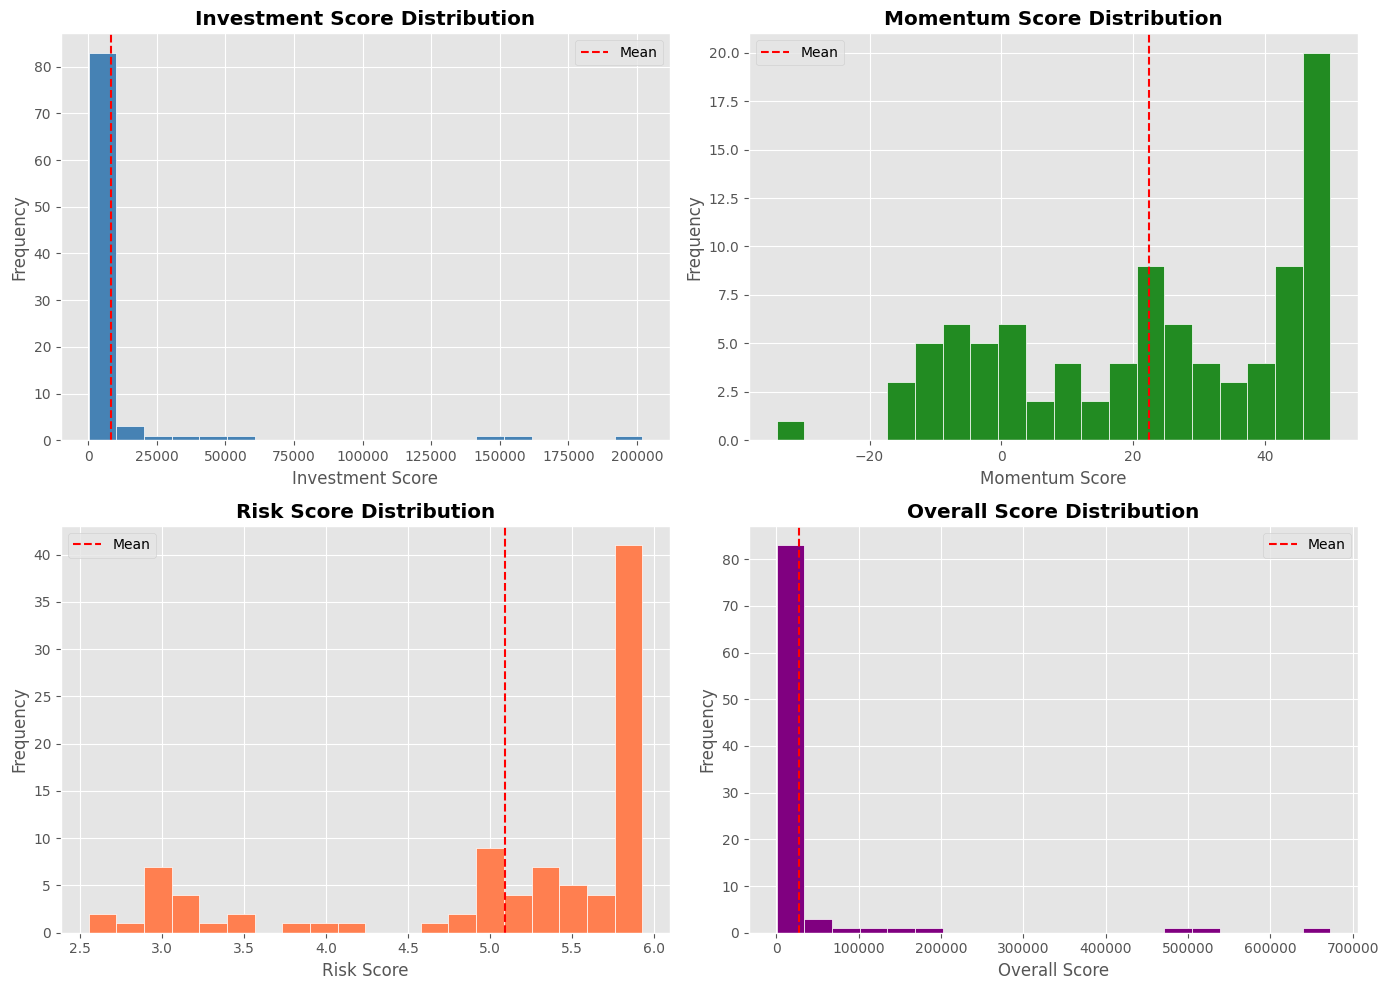

In [24]:
# 1. Score Distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Investment Score
axes[0, 0].hist(df_clean['investment_score'].dropna(), bins=20, color='steelblue', edgecolor='white')
axes[0, 0].set_title('Investment Score Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Investment Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_clean['investment_score'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# Momentum Score
axes[0, 1].hist(df_clean['momentum_score'].dropna(), bins=20, color='forestgreen', edgecolor='white')
axes[0, 1].set_title('Momentum Score Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Momentum Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_clean['momentum_score'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()

# Risk Score
axes[1, 0].hist(df_clean['risk_score'].dropna(), bins=20, color='coral', edgecolor='white')
axes[1, 0].set_title('Risk Score Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Risk Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df_clean['risk_score'].mean(), color='red', linestyle='--', label='Mean')
axes[1, 0].legend()

# Overall Score
axes[1, 1].hist(df_clean['overall_score'].dropna(), bins=20, color='purple', edgecolor='white')
axes[1, 1].set_title('Overall Score Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Overall Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(df_clean['overall_score'].mean(), color='red', linestyle='--', label='Mean')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

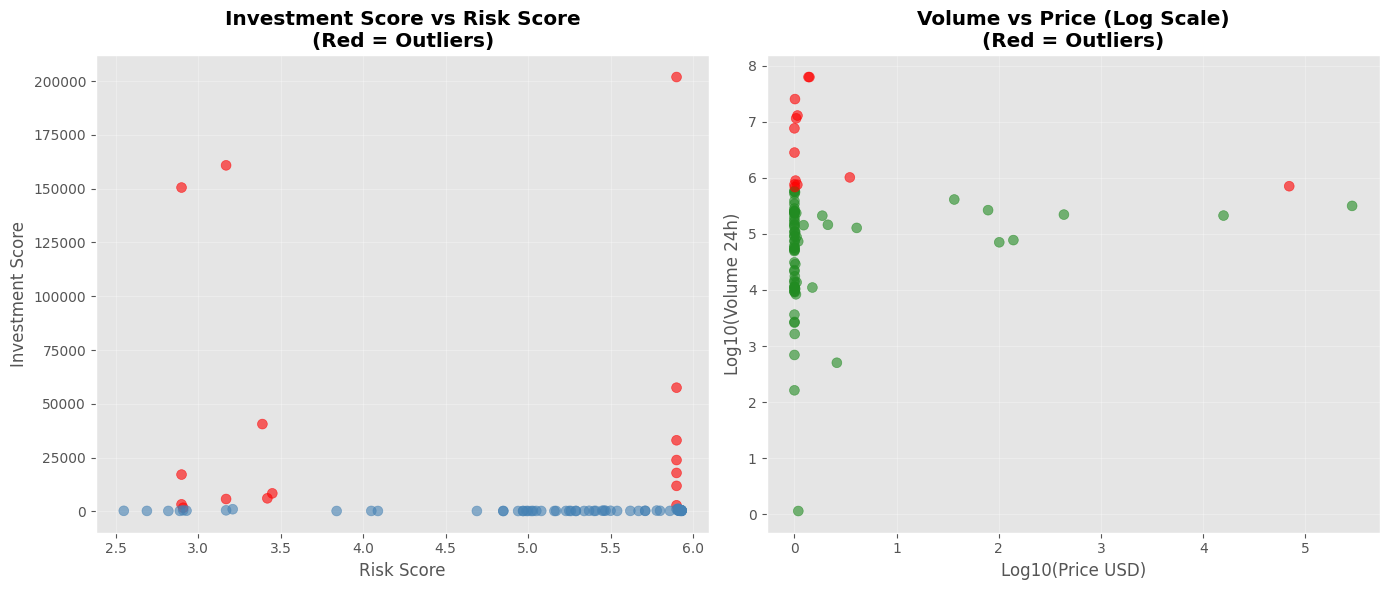

In [25]:
# 2. Scatter Plot for Outlier Detection
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Investment vs Risk Score
colors = ['red' if x else 'steelblue' for x in df_clean.get('investment_score_outlier_iqr', [False]*len(df_clean))]
axes[0].scatter(df_clean['risk_score'], df_clean['investment_score'],
                c=colors, alpha=0.6, s=50)
axes[0].set_xlabel('Risk Score', fontsize=12)
axes[0].set_ylabel('Investment Score', fontsize=12)
axes[0].set_title('Investment Score vs Risk Score\n(Red = Outliers)', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Volume vs Price (log scale)
df_positive = df_clean[(df_clean['volume_24h'] > 0) & (df_clean['price_usd'] > 0)]
colors2 = ['red' if x else 'forestgreen' for x in df_positive.get('volume_24h_outlier_iqr', [False]*len(df_positive))]
axes[1].scatter(np.log10(df_positive['price_usd'] + 1),
                np.log10(df_positive['volume_24h'] + 1),
                c=colors2, alpha=0.6, s=50)
axes[1].set_xlabel('Log10(Price USD)', fontsize=12)
axes[1].set_ylabel('Log10(Volume 24h)', fontsize=12)
axes[1].set_title('Volume vs Price (Log Scale)\n(Red = Outliers)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

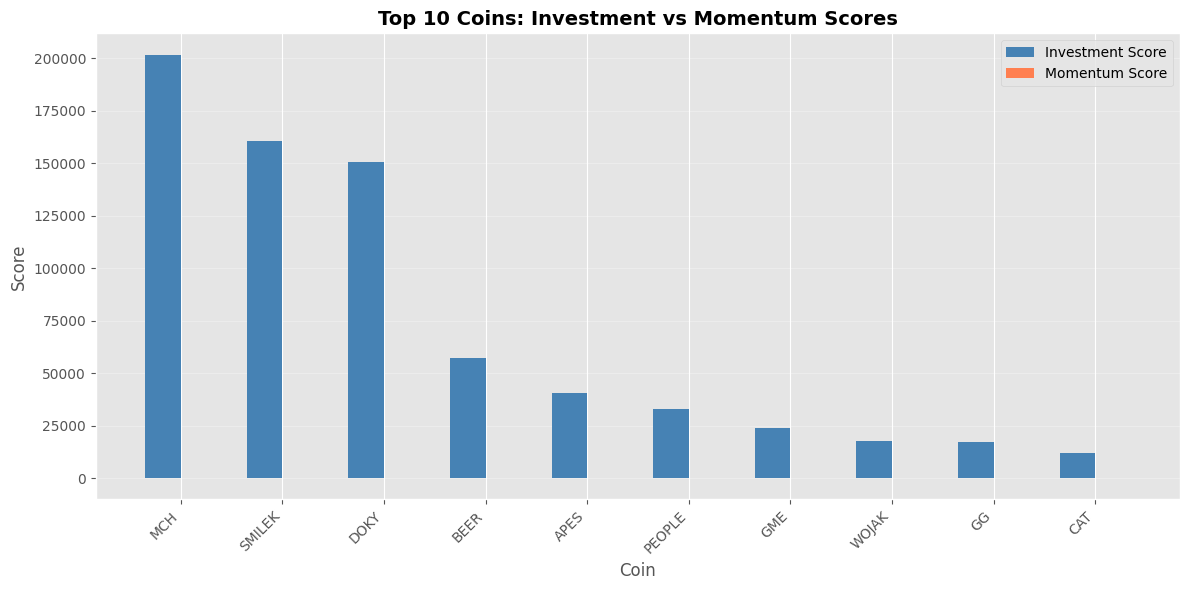

In [26]:
# 3. Top 10 Coins Bar Chart
top10 = df_clean.nlargest(10, 'investment_score')

fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(top10))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], top10['investment_score'], width,
               label='Investment Score', color='steelblue')
bars2 = ax.bar([i + width/2 for i in x], top10['momentum_score'], width,
               label='Momentum Score', color='coral')

ax.set_xlabel('Coin', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Top 10 Coins: Investment vs Momentum Scores', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(top10['symbol'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

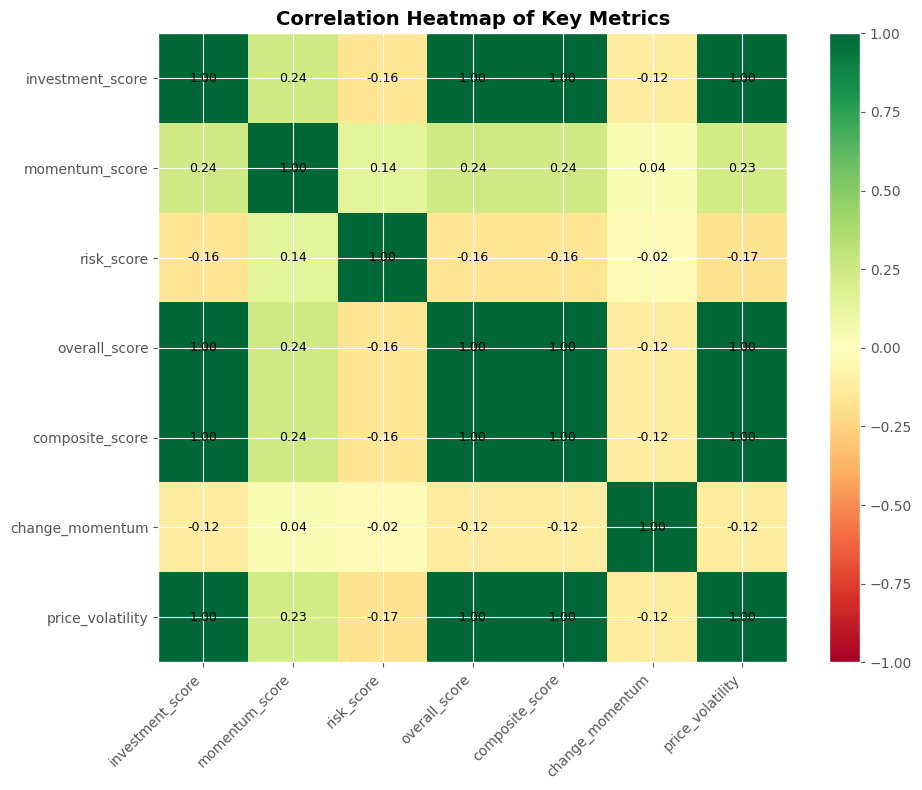

In [27]:
# 4. Correlation Heatmap
score_cols = ['investment_score', 'momentum_score', 'risk_score', 'overall_score',
              'composite_score', 'change_momentum', 'price_volatility']
available = [c for c in score_cols if c in df_clean.columns]

fig, ax = plt.subplots(figsize=(10, 8))
corr = df_clean[available].corr()

# Create heatmap using matplotlib
im = ax.imshow(corr, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(im, ax=ax)
ax.set_xticks(range(len(available)))
ax.set_yticks(range(len(available)))
ax.set_xticklabels(available, rotation=45, ha='right')
ax.set_yticklabels(available)

# Add correlation values as text
for i in range(len(available)):
    for j in range(len(available)):
        ax.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', fontsize=9)

ax.set_title('Correlation Heatmap of Key Metrics', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

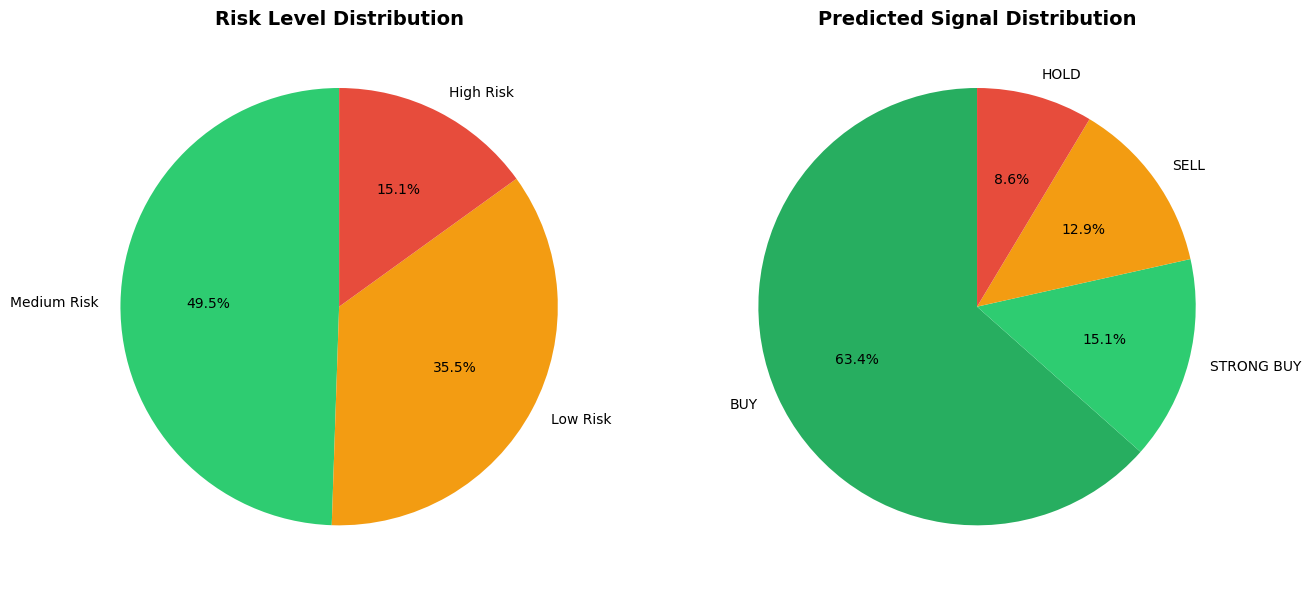

In [28]:
# 5. Risk Level Pie Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Risk Level
risk_counts = df_clean['risk_level'].value_counts()
colors1 = ['#2ecc71', '#f39c12', '#e74c3c']
axes[0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
            colors=colors1, startangle=90)
axes[0].set_title('Risk Level Distribution', fontweight='bold', fontsize=14)

# Signal Distribution
signal_counts = df_clean['predicted_signal'].value_counts()
colors2 = ['#27ae60', '#2ecc71', '#f39c12', '#e74c3c', '#c0392b']
axes[1].pie(signal_counts.values, labels=signal_counts.index, autopct='%1.1f%%',
            colors=colors2[:len(signal_counts)], startangle=90)
axes[1].set_title('Predicted Signal Distribution', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

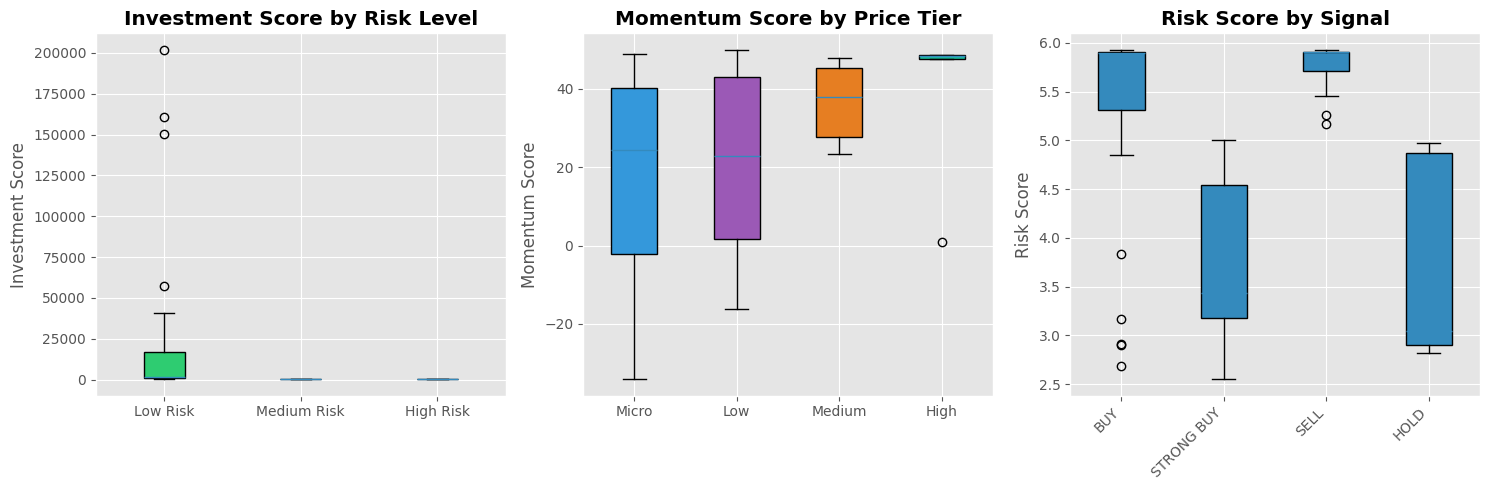

In [29]:
# 6. Box Plots for Score Comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Investment Score by Risk Level
data_inv = [df_clean[df_clean['risk_level'] == level]['investment_score'].dropna()
            for level in ['Low Risk', 'Medium Risk', 'High Risk']]
bp1 = axes[0].boxplot([d for d in data_inv if len(d) > 0], patch_artist=True)
axes[0].set_xticklabels(['Low Risk', 'Medium Risk', 'High Risk'])
axes[0].set_ylabel('Investment Score')
axes[0].set_title('Investment Score by Risk Level', fontweight='bold')
for patch, color in zip(bp1['boxes'], ['#2ecc71', '#f39c12', '#e74c3c']):
    patch.set_facecolor(color)

# Momentum Score by Price Tier
data_mom = [df_clean[df_clean['price_tier'] == tier]['momentum_score'].dropna()
            for tier in ['Micro', 'Low', 'Medium', 'High']]
bp2 = axes[1].boxplot([d for d in data_mom if len(d) > 0], patch_artist=True)
axes[1].set_xticklabels(['Micro', 'Low', 'Medium', 'High'])
axes[1].set_ylabel('Momentum Score')
axes[1].set_title('Momentum Score by Price Tier', fontweight='bold')
for patch, color in zip(bp2['boxes'], ['#3498db', '#9b59b6', '#e67e22', '#1abc9c']):
    patch.set_facecolor(color)

# Risk Score by Signal
signals = df_clean['predicted_signal'].unique()
data_risk = [df_clean[df_clean['predicted_signal'] == sig]['risk_score'].dropna() for sig in signals]
bp3 = axes[2].boxplot([d for d in data_risk if len(d) > 0], patch_artist=True)
axes[2].set_xticklabels(signals, rotation=45, ha='right')
axes[2].set_ylabel('Risk Score')
axes[2].set_title('Risk Score by Signal', fontweight='bold')

plt.tight_layout()
plt.show()

## Section 11: Export Data

In [ ]:
# Create output directories
os.makedirs('output/data', exist_ok=True)
os.makedirs('output/reports', exist_ok=True)

# Export to CSV
df_clean.to_csv('output/data/smartcoins_analyzed.csv', index=False)
print("Exported: output/data/smartcoins_analyzed.csv")

# Export Top 50
top50 = df_clean.nlargest(50, 'investment_score')
top50.to_csv('output/data/top_coins.csv', index=False)
print("Exported: output/data/top_coins.csv")

# Export to SQLite for SQL analysis
conn = sqlite3.connect('output/data/smartcoins.db')
df_clean.to_sql('coins', conn, if_exists='replace', index=False)
conn.close()
print("Exported: output/data/smartcoins.db")

## Section 12: Summary Report

In [30]:
print("=" * 70)
print("SMARTCOINS ANALYSIS SUMMARY REPORT")
print("=" * 70)

print(f"\nTotal Coins Analyzed: {len(df_clean)}")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\n" + "-" * 50)
print("KEY STATISTICS")
print("-" * 50)
print(f"Average Investment Score: {df_clean['investment_score'].mean():.2f}")
print(f"Average Momentum Score: {df_clean['momentum_score'].mean():.2f}")
print(f"Average Risk Score: {df_clean['risk_score'].mean():.2f}")

print("\n" + "-" * 50)
print("TOP 5 INVESTMENT OPPORTUNITIES")
print("-" * 50)
top5 = df_clean.nlargest(5, 'investment_score')[['coin_name', 'symbol', 'investment_score', 'predicted_signal']]
for i, row in top5.iterrows():
    print(f"  {row['symbol']:10s} - Score: {row['investment_score']:6.2f} - Signal: {row['predicted_signal']}")

print("\n" + "-" * 50)
print("SIGNAL DISTRIBUTION")
print("-" * 50)
for signal, count in df_clean['predicted_signal'].value_counts().items():
    print(f"  {signal:15s}: {count:3d} ({count/len(df_clean)*100:.1f}%)")

print("\n" + "-" * 50)
print("SKILLS DEMONSTRATED")
print("-" * 50)
skills = [
    "API Data Extraction (requests)",
    "Data Transformation (pandas)",
    "Data Cleaning and Preprocessing",
    "Statistical Analysis (scipy.stats)",
    "Custom Scoring Functions",
    "Outlier Detection (Z-score, IQR)",
    "Data Visualization (matplotlib)",
    "SQL Database Export (sqlite3)"
]
for skill in skills:
    print(f"  - {skill}")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)

SMARTCOINS ANALYSIS SUMMARY REPORT

Total Coins Analyzed: 93
Analysis Date: 2026-02-11 15:59:00

--------------------------------------------------
KEY STATISTICS
--------------------------------------------------
Average Investment Score: 8283.32
Average Momentum Score: 22.41
Average Risk Score: 5.09

--------------------------------------------------
TOP 5 INVESTMENT OPPORTUNITIES
--------------------------------------------------
  MCH        - Score: 201894.94 - Signal: BUY
  SMILEK     - Score: 160843.24 - Signal: STRONG BUY
  DOKY       - Score: 150518.26 - Signal: STRONG BUY
  BEER       - Score: 57486.64 - Signal: BUY
  APES       - Score: 40566.73 - Signal: STRONG BUY

--------------------------------------------------
SIGNAL DISTRIBUTION
--------------------------------------------------
  BUY            :  59 (63.4%)
  STRONG BUY     :  14 (15.1%)
  SELL           :  12 (12.9%)
  HOLD           :   8 (8.6%)

--------------------------------------------------
SKILLS DEMONSTRA